# Travel Fever: The Impact of Disease Outbreaks in Global Travel

In [3]:
%pylab inline
import pandas as pd
import os
import datetime
import plotly.graph_objects as go
from iso3166 import countries
import requests
import dateutil.parser
import pickle
from bs4 import BeautifulSoup

Populating the interactive namespace from numpy and matplotlib


In [5]:
BTS_dir = '/Users/juan/Google Drive/Brown/2020S/Datathon2020/BTS'

In [6]:
country_codes = [s.replace('"','').split(',') for s in open(os.path.join(BTS_dir,"country_lookup.asp"),'r').read().split('\n')[1:-1]]
country_dict = {s[0]:s[1] for s in country_codes}

In [7]:
# used to simplify getting travel data for a given country
def get_country(country_code):
    '''
    Used to simplify getting travel data for a given country
    '''
    origindf = bts_df[bts_df['ORIGIN_COUNTRY'] == country_code]
    flyCountry = origindf.groupby('DATE')['PASSENGERS'].sum()/1e6
    return flyCountry

def get_country_code(country_name):
    '''
    Use this to go from country name to the 2-letter country code
    '''
    for c in country_codes:
        if country_name.lower() in c[1].lower():
            return c[0]

In [8]:
for c in country_codes:
    if 'Afr' in c[1]:
        print(c)

['CF', 'Central African Republic']
['ZA', 'South Africa']


## Parsing data from the WHO's disease outbreak news

The World Health Organization maintains a website where reports about disease outbreaks are have been posted since 1996. However the data is buried inside a tree of webpages. Here we parse using Beautiful Soup. There's three levels of webpages that need to be scraped.

In [172]:
# level 1
html_doc = requests.get('https://www.who.int/csr/don/archive/country/en/').text
soup = BeautifulSoup(html_doc, 'html.parser')
urls = []
for find in soup.find_all('a'):
    find = str(find)
    if 'country' in str(find):
        if '/csr/don/archive/country/' in str(find):
            urls.append({'url':"https://www.who.int"+find.split('"')[1],
                        'country':find.split('>')[1].split('<')[0]})

In [216]:
# level 2
all_countries = {}
for thing in urls:
    print(thing['country'])
    html_doc = requests.get(thing['url']).text
    soup = BeautifulSoup(html_doc, 'html.parser')
    one_country = []
    for find in soup.find_all('a'):
        find = str(find)
        if (('csr/don' in find) and ('Disease outbreak news' not in find) 
            and ('title=' not in find) and ('/feeds/entity/' not in find)):
            url = "https://www.who.int"+(find.split('"')[1])
            date = find.split('>')[1].split('<')[0]
            one_country.append([url,date])
    titles = []
    for find in soup.find_all('span'):
        find = str(find)
        if (("link_info" in find) and ('Interactive map' not in find)):
            titles.append(find.split(">")[1].split('<')[0])
    final_country = [{'url': s[0],'date': s[1],'title':p} for s,p in zip(one_country,titles)]
    all_countries[thing['country']] = final_country

Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo
Cook Islands
Costa Rica
CÃ´te d'Ivoire
Croatia
Cuba
Cyprus
Czech Republic
Democratic People's Republic of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Federated States of Micronesia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Latvia
Lebanon
Lesotho
Lib

In [242]:
# level 3
mega_countries = {}
done_already=[] # their server might complain, have a way to record the parts well parsed.
for thing in all_countries:
    print(thing)
    if thing in done_already:
        continue
    mega_countries[thing] = []
    for bit in all_countries[thing]:
        the_url = bit['url']
        html_doc = requests.get(the_url).text
        soup = BeautifulSoup(html_doc, 'html.parser')
        desc = soup.find("div",{"id":"primary"}).text
        this_d = {'url': the_url,
                 'title': bit['title'],
                 'date': bit['date'],
                 'description':desc}
        mega_countries[thing].append(this_d)
    done_already.append(thing)

Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo
Cook Islands
Costa Rica
CÃ´te d'Ivoire
Croatia
Cuba
Cyprus
Czech Republic
Democratic People's Republic of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Federated States of Micronesia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Latvia
Lebanon
Lesotho
Lib

In [252]:
# collapse the whole set into a single list of dictionaries
super_countries = []
for thing in mega_countries:
    for bunny in mega_countries[thing]:
        bunny['country'] = thing
        super_countries.append(bunny)

In [288]:
# now make that into a dataframe
who_df = pd.DataFrame(super_countries)

In [36]:
# good to have this for grouping and aggregation
#who_df['date'] = who_df['date'].apply(lambda x: dateutil.parser.parse(x))
who_df['month'] = who_df['date'].apply(lambda x: x.month)
who_df['year'] = who_df['date'].apply(lambda x: x.year)

In [291]:
#who_df.set_index('date', inplace=True)

## Read and analyze air-travel data

In [9]:
# read the individual files into a list of Dataframes and then mush them together
# keeping only information for flights that originated outside of the US
dfs = []
for year in range(1990,2020):
    yeardf = pd.read_csv(os.path.join(BTS_dir,"%d.csv" % year))
    yeardf = yeardf[yeardf['ORIGIN_COUNTRY'] != "US"]
    yeardf = yeardf[yeardf['PASSENGERS'] > 0]
    dfs.append(yeardf)
bts_df = pd.concat(dfs)
del(dfs)

In [10]:
# parse a proper datetime date
years = list(bts_df['YEAR'])
months = list(bts_df['MONTH'])
dates = [datetime.datetime(year=yr,month=mon,day=1) for (yr, mon) in zip(years, months)]
bts_df['DATE'] = dates

In [13]:
bts_df

,PASSENGERS,DISTANCE,AIR_TIME,ORIGIN_COUNTRY,DEST_COUNTRY,YEAR,MONTH,Unnamed: 7,DATE
12943,1.0,1330.0,154.0,KI,US,1990,4,NaN,1990-04-01
12946,1.0,713.0,88.0,CA,US,1990,7,NaN,1990-07-01
12994,1.0,183.0,34.0,BS,US,1990,1,NaN,1990-01-01
12995,1.0,717.0,98.0,JM,US,1990,1,NaN,1990-01-01
12997,1.0,1498.0,0.0,CA,US,1990,4,NaN,1990-04-01
...,...,...,...,...,...,...,...,...,...
322802,38371.0,3452.0,0.0,GB,US,2019,4,NaN,2019-04-01
322817,38884.0,3452.0,0.0,GB,US,2019,6,NaN,2019-06-01
322825,39103.0,3452.0,0.0,GB,US,2019,8,NaN,2019-08-01
322855,40006.0,3452.0,0.0,GB,US,2019,5,NaN,2019-05-01


### 2D Plots

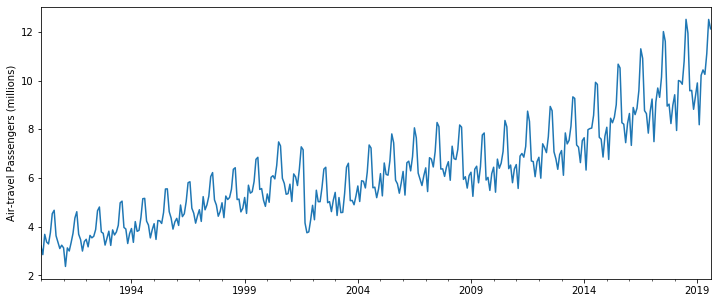

In [21]:
# total flights into the US
flyUS = bts_df.groupby('DATE')['PASSENGERS'].sum()/1e6
plt.figure(figsize=(12,5))
flyUS.plot()
plt.xlabel('')
plt.ylabel('Air-travel Passengers (millions)')
plt.savefig('Final - Total travel into the US.pdf')
plt.show()

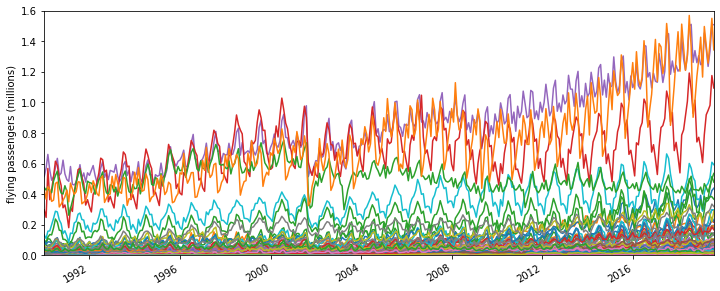

In [24]:
# Plot all countries
plt.figure(figsize=(12,5))
for cn_code in country_dict:
    try:
        flyCountry = get_country(cn_code)
        flyCountry.plot(logy=False,label=country_dict[cn_code])
    except:
        pass
plt.xlabel('')
plt.ylabel('flying passengers (millions)')
plt.ylim(0,1.6)
plt.savefig('Final - Travel into the US per country of origin.pdf')
plt.show()

Try and see if there's any discernible effects of known disease outbreaks.

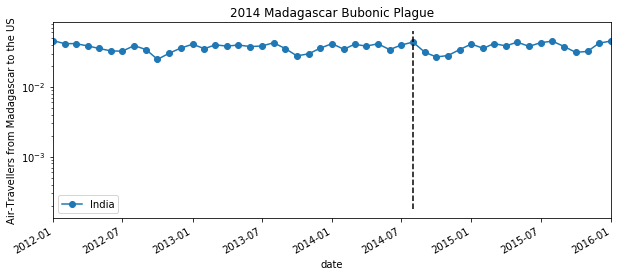

In [25]:
# 2014 Madagascar Bubonic Plague
# https://en.wikipedia.org/wiki/2014_Madagascar_plague_outbreak
focus_year = 2014
min_year = focus_year-2
max_year = focus_year+2
c_names = ['India']
tit = '2014 Madagascar Bubonic Plague'
c_codes = [get_country_code(s) for s in c_names]
plt.figure(figsize=(10,4))
for c_code in c_codes:
    try:
        c_name = country_dict[c_code]
        flyCountry = get_country(c_code)
        flyCountry.plot(marker='o',logy=True,label=c_name)
        plt.plot([datetime.datetime(year=focus_year,month=8,day=1),
                 datetime.datetime(year=focus_year,month=8,day=1)],[min(flyCountry),
                                                                    max(flyCountry)],'k--')
    except:
        pass
plt.ylabel('Air-Travellers from Madagascar to the US')
plt.xlabel('date')
plt.xlim(datetime.datetime(year=min_year,month=1,day=1),
                 datetime.datetime(year=max_year,month=1,day=1))
plt.legend()
plt.title(tit)
plt.savefig('Final - Madagascar - Bubonic Plague.pdf')
plt.show()

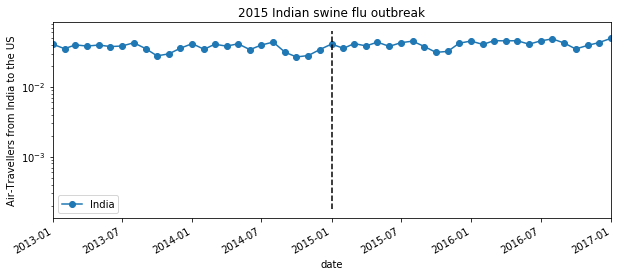

In [27]:
# India swine flue outbreak 2015
# https://en.wikipedia.org/wiki/2015_Indian_swine_flu_outbreak
focus_year = 2015
min_year = focus_year-2
max_year = focus_year+2
c_names = ['India']
tit = '2015 Indian swine flu outbreak'
c_codes = [get_country_code(s) for s in c_names]
plt.figure(figsize=(10,4))
for c_code in c_codes:
    try:
        c_name = country_dict[c_code]
        flyCountry = get_country(c_code)
        flyCountry.plot(marker='o',logy=True,label=c_name)
        plt.plot([datetime.datetime(year=focus_year,month=1,day=1),
                 datetime.datetime(year=focus_year,month=1,day=1)],[min(flyCountry),
                                                                    max(flyCountry)],'k--')
    except:
        pass
plt.ylabel('Air-Travellers from India to the US')
plt.xlabel('date')
plt.xlim(datetime.datetime(year=min_year,month=1,day=1),
                 datetime.datetime(year=max_year,month=1,day=1))
plt.legend()
plt.title(tit)
plt.savefig('Final - India - Swine Flu.pdf')
plt.show()

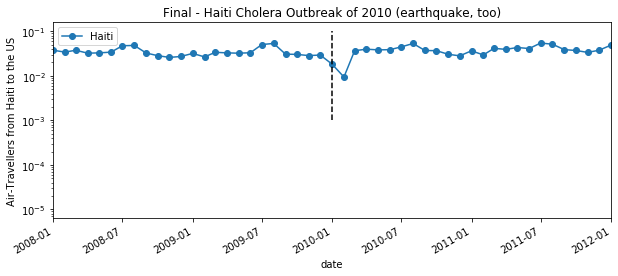

In [28]:
# Haiti Cholera outbreak just after the big earthquake
# https://en.wikipedia.org/wiki/Haiti_cholera_outbreak
min_year = 2008
max_year = 2012
focus_year = 2010
c_names = ['Haiti']
c_codes = [get_country_code(s) for s in c_names]
plt.figure(figsize=(10,4))
for c_code in c_codes:
    try:
        c_name = country_dict[c_code]
        flyCountry = get_country(c_code)
        flyCountry.plot(marker='o',logy=True,label=c_name)
        plt.plot([datetime.datetime(year=focus_year,month=1,day=1),
                 datetime.datetime(year=focus_year,month=1,day=1)],[1e-3,1e-1],'k--')
    except:
        pass
plt.ylabel('Air-Travellers from Haiti to the US')
plt.xlabel('date')
plt.xlim(datetime.datetime(year=min_year,month=1,day=1),
                 datetime.datetime(year=max_year,month=1,day=1))
plt.legend()
plt.title('Final - Haiti Cholera Outbreak of 2010 (earthquake, too)')

plt.show()

/Users/juan/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 730425.0 results in singular transformations; automatically expanding.



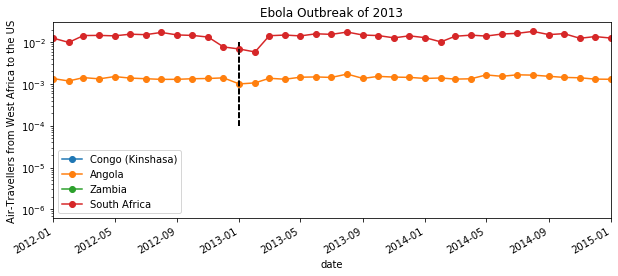

In [30]:
# EBOLA outbreak in West-Africa
# The outbreak was worst in Congo but there's no direct flights
# from there to the US. Neighbouring countries do show a response to it
min_year = 2012
max_year = 2015
focus_year = 2013
c_names = ['Congo','Angola','Namibia','Gabon','Zambia','Tanzania','South Africa',
          'Botswana','Mozambique']
c_codes = [get_country_code(s) for s in c_names]
plt.figure(figsize=(10,4))
for c_code in c_codes:
    try:
        c_name = country_dict[c_code]
        flyCountry = get_country(c_code)
        flyCountry.plot(marker='o',logy=True,label=c_name)
        plt.plot([datetime.datetime(year=focus_year,month=1,day=1),
                 datetime.datetime(year=focus_year,month=1,day=1)],[1e-4,1e-2],'k--')
    except:
        pass
plt.ylabel('Air-Travellers from West Africa to the US')
plt.xlabel('date')
plt.xlim(datetime.datetime(year=min_year,month=1,day=1),
                 datetime.datetime(year=max_year,month=1,day=1))
plt.legend()
plt.title('Ebola Outbreak of 2013')
plt.savefig('Final - Ebola Outbreak of 2013.pdf')
plt.show()

In [14]:
# use this to save the dataframe to an Excel spreadsheet
# bts_df.to_excel(os.path.join(BTS_dir,'BTS.xlsx'))

### Choropleth set of figures to show sources of incoming air-travel

In [16]:
# must be able to go back from the two to the 
# three letter abbreviation for countries
two_to_three = {}
for c in countries:
    two_to_three[c.alpha2] = c.alpha3
two_to_three['AN'] = 'ANT'
two_to_three['SU'] = 'RUS'
two_to_three['YU'] = 'ME'
two_to_three['CS'] = 'ME'

In [30]:
fig_index = 0
for travel_year in range(1990,2020):
    print(travel_year)
    for month in range(1,13):
        small_df = bts_df[bts_df['YEAR'] == travel_year]
        small_df = small_df[small_df['MONTH'] == month]
        small_df = small_df[small_df['DEST_COUNTRY'] == 'US']
        #small_df.dropna(inplace=True)
        small_df = small_df[~small_df['ORIGIN_COUNTRY'].isna()]
        small_df['ORIGIN_COUNTRY_3'] = small_df['ORIGIN_COUNTRY'].apply(lambda x: two_to_three[x])
        small_df['DEST_COUNTRY_3'] = small_df['DEST_COUNTRY'].apply(lambda x: two_to_three[x])
        grouped_df = small_df.groupby(['MONTH','ORIGIN_COUNTRY_3'])['PASSENGERS'].sum().reset_index()
        fig = go.Figure(data=go.Choropleth(
            locations = grouped_df['ORIGIN_COUNTRY_3'],
            z = grouped_df['PASSENGERS'],
            text = grouped_df['ORIGIN_COUNTRY_3'],
            colorscale = 'Magma',
            autocolorscale=False,
            reversescale=False,
            zmin=0,
            zmax=1e6,
            marker_line_color='darkgray',
            marker_line_width=0.5,
            colorbar_tickprefix = '',
            colorbar_title = 'Air Travelers in Millions',
        ))

        fig.update_layout(
            title_text='%d-%d' % (travel_year, month),
            title_font = {'size': 60},
            width=1800,
            height=1000,
            geo=dict(
                showframe=False,
                showcoastlines=False,
                projection_type='equirectangular',
                landcolor='black'
            ),
#             annotations = [dict(
#                 x=0.55,
#                 y=0.1,
#                 xref='paper',
#                 yref='paper',
# #                 text='Source: <a href="https://www.bts.gov/">\
# #                     Bureau of Transportation Statistics</a>',
#                 showarrow = False
#             )]
        )
        fig_index_str = str(fig_index).zfill(3)
        fig.write_image('./mapframes/%s.png' % fig_index_str)
        fig_index = fig_index + 1
        #fig.show()

1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


## Analyze correlation between air travel and number of outbreak reports submitted to the WHO

Finally search for correlations between the reports send to the WHO and the number of passengers travelling from different countries to the US

In [32]:
!ls | grep who

who-dos.pkl
whodf-dos.pkl


In [33]:
who_df = pd.read_pickle('whodf-dos.pkl')

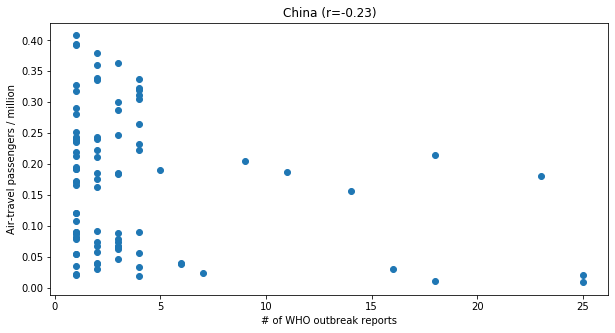

In [40]:
country_c = 'CN'
country_name = country_dict[country_c]
who_country = who_df[who_df['country'] == country_name].groupby(pd.Grouper(key='date',freq="M")).apply(lambda x:x)
who_counts = []
for year in range(1996,2020):
    for month in range(1,13):
        who_counts.append([datetime.datetime(year=year, month=month, day=1),
                     sum((who_country['year'] == year) & (who_country['month'] == month))])
who_counts_df = pd.DataFrame(who_counts, columns = ['date','#reports'])
who_counts_df['year-month'] = who_counts_df['date'].apply(lambda x: datetime.datetime(year=x.year,month=x.month,day=1))
who_counts_df.set_index('year-month',inplace=True)
who_counts_df.columns=['DATE','#reports']
super_who = pd.merge_asof(pd.DataFrame(get_country(country_c)), who_counts_df, on='DATE')
super_who = super_who[super_who["#reports"] != 0]
corr = super_who.corr()['PASSENGERS']["#reports"]
plt.figure(figsize=(10,5))
plt.plot(super_who['#reports'],super_who['PASSENGERS'],'o')
plt.ylabel('Air-travel passengers / million')
plt.xlabel('# of WHO outbreak reports')
plt.title(country_name+" (r=%.2f)"%corr)
plt.savefig('Final - Correlation China into the US.pdf')
plt.show()

In [41]:
correlations = []
country_names = list(sorted(set(who_df['country'])))
for country_name in country_names:
    try:
        who_country = who_df[who_df['country'] == country_name].groupby(pd.Grouper(key='date',freq="M")).apply(lambda x:x)
        who_counts = []
        for year in range(1996,2020):
            for month in range(1,13):
                who_counts.append([datetime.datetime(year=year, month=month, day=1),
                             sum((who_country['year'] == year) & (who_country['month'] == month))])
        who_counts_df = pd.DataFrame(who_counts, columns = ['date','#reports'])
        who_counts_df['year-month'] = who_counts_df['date'].apply(lambda x: datetime.datetime(year=x.year,month=x.month,day=1))
        who_counts_df.set_index('year-month',inplace=True)
        who_counts_df.columns=['DATE','#reports']
        super_who = pd.merge_asof(pd.DataFrame(get_country(country_c)), who_counts_df, on='DATE')
        #super_who = super_who[super_who["#reports"] != 0]
        corr = super_who.corr()['PASSENGERS']["#reports"]
        correlations.append([country_name,corr])
    except:
        pass

In [42]:
correlations = np.array(correlations)
correlations = correlations[correlations[:,1] != 'nan']
corrs = correlations[:,1].astype(np.float64);
correlations=correlations[np.argsort(corrs)]

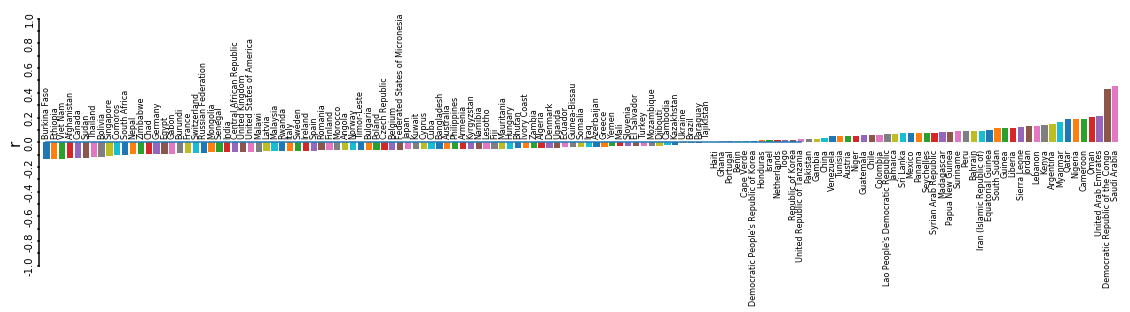

In [44]:
correlations = np.array(correlations)
fig,ax = plt.subplots(figsize=(20,5))
for i in range(len(correlations)):
    #print(float(correlations[i][1]))
    plt.bar([i],
            [float(correlations[i][1])])
plt.xlim(-5,137)
plt.plot([0,96],[0,0])
plt.ylabel('r', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.plot([-1,-1],[-1,1],'k-')
for y in np.linspace(-1,1,21):
    plt.plot([-1.1,-0.9],[y,y],'k')
    if np.round(y,1) in np.array([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0]):
        plt.text(-1.5,y,'%.1f'%y,ha='right',rotation=90,va='center')
for idx, corre in enumerate(correlations):
    corrf = float(corre[1])
    nam = corre[0]
    if "Britain" in nam:
        nam = "United Kingdom"
    if 'Ivoire' in nam:
        nam = "Ivory Coast"
    if corrf<0:
        plt.text(idx,0.05,nam,rotation=90,ha='center',fontsize=8)
    else:
        plt.text(idx,-0.05,nam,rotation=90,va='top',ha='center',fontsize=8)
#     plt.plot([0,correlations[i][1]],[i,i])
plt.text(-5,0,"r",fontsize=15,rotation=90)
ax.axis('off')
plt.savefig('Final - Pearson-r-with-zeros.pdf')
plt.show()

In [45]:
correlations = []
country_names = list(sorted(set(who_df['country'])))
for country_name in country_names:
    try:
        who_country = who_df[who_df['country'] == country_name].groupby(pd.Grouper(key='date',freq="M")).apply(lambda x:x)
        who_counts = []
        for year in range(1996,2020):
            for month in range(1,13):
                who_counts.append([datetime.datetime(year=year, month=month, day=1),
                             sum((who_country['year'] == year) & (who_country['month'] == month))])
        who_counts_df = pd.DataFrame(who_counts, columns = ['date','#reports'])
        who_counts_df['year-month'] = who_counts_df['date'].apply(lambda x: datetime.datetime(year=x.year,month=x.month,day=1))
        who_counts_df.set_index('year-month',inplace=True)
        who_counts_df.columns=['DATE','#reports']
        super_who = pd.merge_asof(pd.DataFrame(get_country(country_c)), who_counts_df, on='DATE')
        super_who = super_who[super_who["#reports"] != 0]
        corr = super_who.corr()['PASSENGERS']["#reports"]
        correlations.append([country_name,corr])
    except:
        pass

In [46]:
correlations = np.array(correlations)
correlations = correlations[correlations[:,1] != 'nan']
corrs = correlations[:,1].astype(np.float64);
correlations=correlations[np.argsort(corrs)]

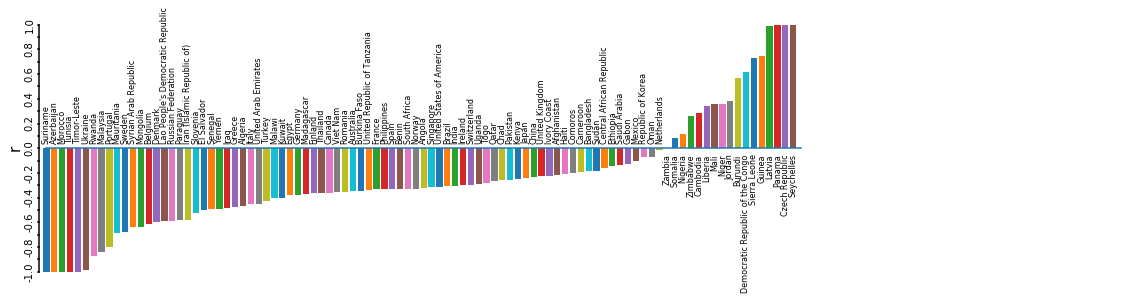

In [47]:
correlations = np.array(correlations)
fig,ax = plt.subplots(figsize=(20,5))
for i in range(len(correlations)):
    #print(float(correlations[i][1]))
    plt.bar([i],
            [float(correlations[i][1])])
plt.xlim(-5,137)
plt.plot([0,96],[0,0])
plt.ylabel('r', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.plot([-1,-1],[-1,1],'k-')
for y in np.linspace(-1,1,21):
    plt.plot([-1.1,-0.9],[y,y],'k')
    if np.round(y,1) in np.array([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0]):
        plt.text(-1.5,y,'%.1f'%y,ha='right',rotation=90,va='center')
for idx, corre in enumerate(correlations):
    corrf = float(corre[1])
    nam = corre[0]
    if "Britain" in nam:
        nam = "United Kingdom"
    if 'Ivoire' in nam:
        nam = "Ivory Coast"
    if corrf<0:
        plt.text(idx,0.05,nam,rotation=90,ha='center',fontsize=8)
    else:
        plt.text(idx,-0.05,nam,rotation=90,va='top',ha='center',fontsize=8)
#     plt.plot([0,correlations[i][1]],[i,i])
plt.text(-5,0,"r",fontsize=15,rotation=90)
ax.axis('off')
plt.savefig('Final - Pearson-r-with-zeros.pdf')
plt.show()

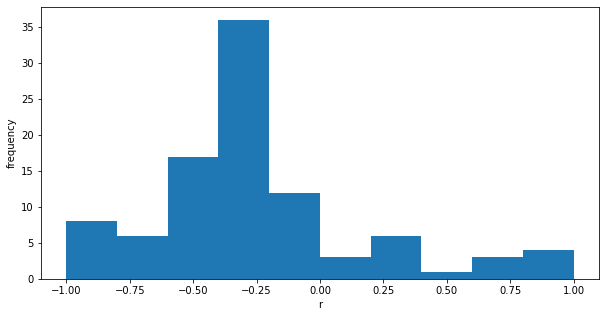

In [51]:
plt.figure(figsize=(10,5))
plt.hist([float(c[1]) for c in correlations])
plt.xlabel('r')
plt.ylabel('frequency')
plt.savefig('Final - histogram of r with no zeros.pdf')
plt.show()